In [1]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
import warnings


from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor



warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)d

# We are using cuda powered dataframes which are 16x faster then pandas dataframes

In [47]:
import cudf

In [2]:
Sales_Data_url='https://drive.google.com/uc?id=1b9T0ZLpoITsb1A4u69-ykl6T5Skct4ER'
Store_Data_url ='https://drive.google.com/uc?id=1EaEpVwZdl3K-AzQljWQFfyUaazxV7l2Z'

In [3]:
Sales_Data = pd.read_csv(Sales_Data_url)
Store_Data = pd.read_csv(Store_Data_url)

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #/MyDrive/PlacementProject/

In [ ]:
Sales_Data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,31-07-2015,5263,555,1,1,0,1
1,2,5,31-07-2015,6064,625,1,1,0,1
2,3,5,31-07-2015,8314,821,1,1,0,1
3,4,5,31-07-2015,13995,1498,1,1,0,1
4,5,5,31-07-2015,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,01-01-2013,0,0,0,0,a,1
1017205,1112,2,01-01-2013,0,0,0,0,a,1
1017206,1113,2,01-01-2013,0,0,0,0,a,1
1017207,1114,2,01-01-2013,0,0,0,0,a,1


In [ ]:
Store_Data

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,<NA>,<NA>,<NA>
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,<NA>,<NA>,<NA>
4,5,a,a,29910,4,2015,0,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900,6,2014,1,31,2013,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880,4,2006,0,<NA>,<NA>,<NA>
1112,1113,a,c,9260,<NA>,<NA>,0,<NA>,<NA>,<NA>
1113,1114,a,c,870,<NA>,<NA>,0,<NA>,<NA>,<NA>


# Evaluation Metrics

In [5]:
def root_mean_square_error(y_true,y_pred):
    return pow(mean_squared_error(y_true,y_pred),1/2)

In [6]:
Merged_Sales_Data = pd.merge(Sales_Data,Store_Data,on='Store',how='inner')

In [ ]:
Merged_Sales_Data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,753,5,31-07-2015,9303,767,1,1,0,1,d,c,540,11,2012,1,35,2010,"Mar,Jun,Sept,Dec"
1,754,5,31-07-2015,8920,927,1,1,0,1,c,c,380,5,2008,1,10,2014,"Mar,Jun,Sept,Dec"
2,755,5,31-07-2015,12426,995,1,1,0,1,d,c,13130,12,2003,0,<NA>,<NA>,<NA>
3,756,5,31-07-2015,25280,2901,1,1,0,1,a,c,50,<NA>,<NA>,1,40,2011,"Jan,Apr,Jul,Oct"
4,757,5,31-07-2015,9343,684,1,1,0,1,a,c,3450,<NA>,<NA>,0,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,450,2,01-01-2013,0,0,0,0,a,1,c,a,5780,11,1994,1,10,2014,"Mar,Jun,Sept,Dec"
1017205,455,2,01-01-2013,0,0,0,0,a,1,d,c,7660,9,2010,0,<NA>,<NA>,<NA>
1017206,459,2,01-01-2013,0,0,0,0,a,1,a,a,250,9,2008,1,5,2013,"Feb,May,Aug,Nov"
1017207,461,2,01-01-2013,0,0,0,0,a,1,d,c,1790,7,2013,1,40,2013,"Jan,Apr,Jul,Oct"


In [54]:
del(Sales_Data)
del(Store_Data)

In [ ]:
# pd.set_option('display.max_rows',100)
Merged_Sales_Data


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,753,5,31-07-2015,9303,767,1,1,0,1,d,c,540,11,2012,1,35,2010,"Mar,Jun,Sept,Dec"
1,754,5,31-07-2015,8920,927,1,1,0,1,c,c,380,5,2008,1,10,2014,"Mar,Jun,Sept,Dec"
2,755,5,31-07-2015,12426,995,1,1,0,1,d,c,13130,12,2003,0,<NA>,<NA>,<NA>
3,756,5,31-07-2015,25280,2901,1,1,0,1,a,c,50,<NA>,<NA>,1,40,2011,"Jan,Apr,Jul,Oct"
4,757,5,31-07-2015,9343,684,1,1,0,1,a,c,3450,<NA>,<NA>,0,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,450,2,01-01-2013,0,0,0,0,a,1,c,a,5780,11,1994,1,10,2014,"Mar,Jun,Sept,Dec"
1017205,455,2,01-01-2013,0,0,0,0,a,1,d,c,7660,9,2010,0,<NA>,<NA>,<NA>
1017206,459,2,01-01-2013,0,0,0,0,a,1,a,a,250,9,2008,1,5,2013,"Feb,May,Aug,Nov"
1017207,461,2,01-01-2013,0,0,0,0,a,1,d,c,1790,7,2013,1,40,2013,"Jan,Apr,Jul,Oct"


In [ ]:
Merged_Sales_Data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1017209 entries, 0 to 1017208

Data columns (total 18 columns):

 #   Column                     Non-Null Count    Dtype  

---  ------                     --------------    -----  

 0   Store                      1017209 non-null  int64  

 1   DayOfWeek                  1017209 non-null  int64  

 2   Date                       1017209 non-null  object 

 3   Sales                      1017209 non-null  int64  

 4   Customers                  1017209 non-null  int64  

 5   Open                       1017209 non-null  int64  

 6   Promo                      1017209 non-null  int64  

 7   StateHoliday               1017209 non-null  object 

 8   SchoolHoliday              1017209 non-null  int64  

 9   StoreType                  1017209 non-null  object 

 10  Assortment                 1017209 non-null  object 

 11  CompetitionDistance        1014567 non-null  float64

 12  CompetitionOpenSinceMonth  693861 non-null   float64


In [9]:
Merged_Sales_Data['Date'] = pd.to_datetime(Merged_Sales_Data['Date'],format='%d-%m-%Y')
Merged_Sales_Data['Year'] = Merged_Sales_Data['Date'].dt.year
Merged_Sales_Data['Month'] = Merged_Sales_Data['Date'].dt.month
Merged_Sales_Data['Day'] = Merged_Sales_Data['Date'].dt.day
Merged_Sales_Data['WeekOfYear'] = Merged_Sales_Data['Date'].dt.isocalendar()['week']

In [ ]:
# Merged_Sales_Data.sort_values(by='Date',inplace=True,ignore_index=True)

In [ ]:
Merged_Sales_Data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,753,5,2015-07-31,9303,767,1,1,0,1,d,...,11,2012,1,35,2010,"Mar,Jun,Sept,Dec",2015,7,31,31
1,754,5,2015-07-31,8920,927,1,1,0,1,c,...,5,2008,1,10,2014,"Mar,Jun,Sept,Dec",2015,7,31,31
2,755,5,2015-07-31,12426,995,1,1,0,1,d,...,12,2003,0,<NA>,<NA>,<NA>,2015,7,31,31
3,756,5,2015-07-31,25280,2901,1,1,0,1,a,...,<NA>,<NA>,1,40,2011,"Jan,Apr,Jul,Oct",2015,7,31,31
4,757,5,2015-07-31,9343,684,1,1,0,1,a,...,<NA>,<NA>,0,<NA>,<NA>,<NA>,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,450,2,2013-01-01,0,0,0,0,a,1,c,...,11,1994,1,10,2014,"Mar,Jun,Sept,Dec",2013,1,1,1
1017205,455,2,2013-01-01,0,0,0,0,a,1,d,...,9,2010,0,<NA>,<NA>,<NA>,2013,1,1,1
1017206,459,2,2013-01-01,0,0,0,0,a,1,a,...,9,2008,1,5,2013,"Feb,May,Aug,Nov",2013,1,1,1
1017207,461,2,2013-01-01,0,0,0,0,a,1,d,...,7,2013,1,40,2013,"Jan,Apr,Jul,Oct",2013,1,1,1


In [10]:
Train = Merged_Sales_Data[Merged_Sales_Data['Year'] != 2015].copy()
Test = Merged_Sales_Data[Merged_Sales_Data['Year'] == 2015].copy()

Training Set: 76.76% of the total Train

Test Set: 23.24% of the total Train


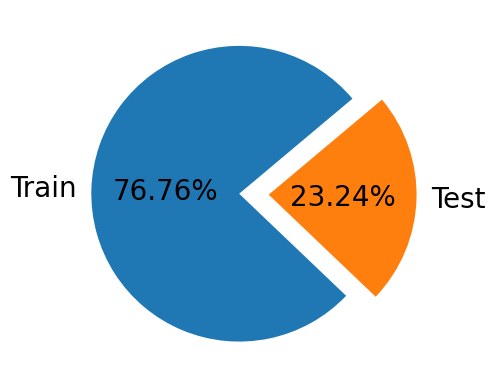

In [11]:
Train_percentage = (Train.shape[0] * 100) / Merged_Sales_Data.shape[0]
test_percentage = (Test.shape[0] * 100) / Merged_Sales_Data.shape[0]
plt.pie([Train_percentage,test_percentage],labels=['Train','Test'],autopct='%.2f%%',explode=[.1,.1],textprops=dict(size=20,color='black'),pctdistance=.5,startangle=40)
print(f"Training Set: {Train_percentage:.2f}% of the total Train")
print(f"Test Set: {test_percentage:.2f}% of the total Train")


In [ ]:
Train.shape, Test.shape

((780829, 22), (236380, 22))

In [12]:
del(Merged_Sales_Data)

In [ ]:
# to_analyse=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers',
#        'StateHoliday', 'SchoolHoliday',  'Assortment',


#    'PromoInterval', 'Year', 'Month', 'Day',
#        'WeekOfYear',]

In [ ]:
Train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
236380,1,3,2014-12-31,2605,327,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2014,12,31,1
236381,2,3,2014-12-31,2269,252,1,0,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2014,12,31,1
236382,3,3,2014-12-31,3804,408,1,0,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2014,12,31,1
236383,4,3,2014-12-31,10152,1311,1,0,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2014,12,31,1
236384,5,3,2014-12-31,1830,217,1,0,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2014,12,31,1


In [ ]:
Train.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2006
CompetitionOpenSinceMonth    248300
CompetitionOpenSinceYear     248300
Promo2                            0
Promo2SinceWeek              392703
Promo2SinceYear              392703
PromoInterval                392703
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
dtype: int64

In [ ]:
Train['Date'].describe()

count                           780829
mean     2013-12-19 22:05:54.868991744
min                2013-01-01 00:00:00
25%                2013-06-25 00:00:00
50%                2013-12-17 00:00:00
75%                2014-06-10 00:00:00
max                2014-12-31 00:00:00
Name: Date, dtype: object

In [ ]:
Test['Date'].describe()

count                           236380
mean     2015-04-16 12:00:00.000000256
min                2015-01-01 00:00:00
25%                2015-02-22 18:00:00
50%                2015-04-16 12:00:00
75%                2015-06-08 06:00:00
max                2015-07-31 00:00:00
Name: Date, dtype: object

# Sales

<Axes: xlabel='Sales', ylabel='Count'>

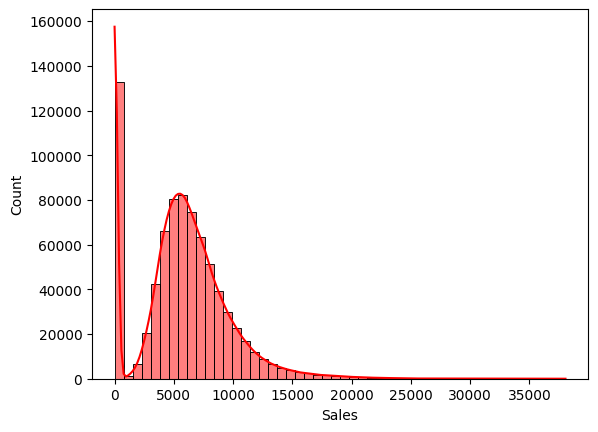

In [ ]:
sns.histplot(
    Train['Sales'],
    color='red',
    kde=True,
    bins=50)

**Inferences** It seems two groups in Sales, One seems log normally distributed(approx) and one is distributed at 0.
- We will uncover this soon.

# StoreType, Sales and Status(open=1/0)

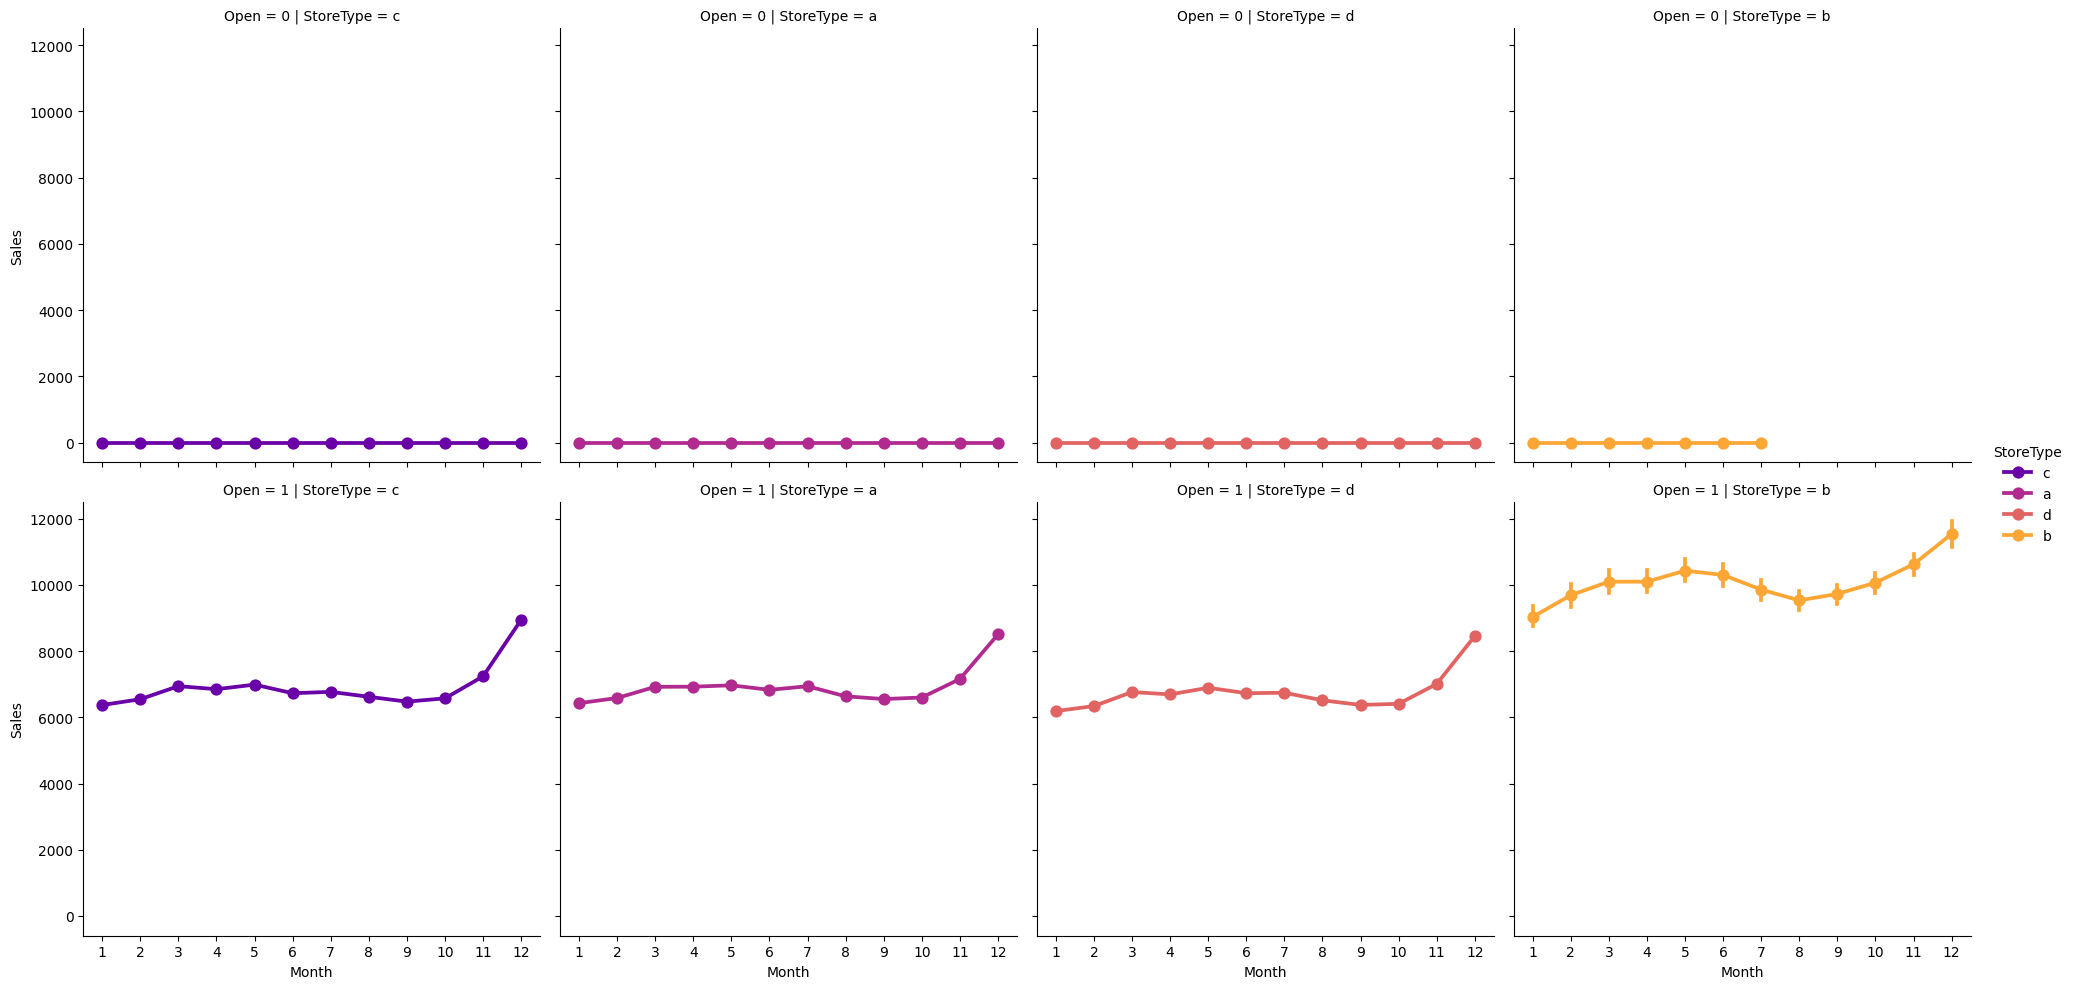

In [ ]:

sns.catplot(
    x='Month',
    y='Sales',
    data=Train,
    col='StoreType',
    palette='plasma',
    hue='StoreType',
    row='Open',
kind='point')

In [ ]:
pd.set_option('display.max_rows',24)
Train[['Sales','Open','StoreType']].groupby(['Open','StoreType']).median()

Sales
Open StoreType        
0    a             0.0
     b             0.0
     c             0.0
     d             0.0
1    a          6253.0
     b          8978.0
     c          6363.0
     d          6314.0

<Axes: xlabel='Sales', ylabel='Count'>

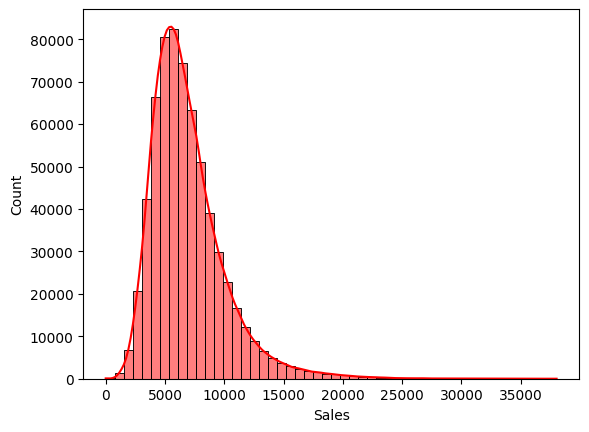

In [ ]:
sns.histplot(Train[Train['Open']==1]['Sales'],color='red',kde=True,bins=50)

**Inference :** Sales are zero whenever the store is closed. So Open = 0, (Store Closed) is not providing any significant information.
So it is good to use only information where Open=0.

In [ ]:
len(Train)

780829

In [59]:
Train = Train[Train['Open']==1]
Test = Test[Test['Open']==1]

In [ ]:
len(Train)

648360

In [ ]:
780829 -  648360

132469

In [ ]:
Train[Train['Open']==0].shape

(0, 22)

In [ ]:

print(Train['Sales'].agg(['skew','kurtosis']))
Train['Sales'].describe()

skew        1.616195

kurtosis    4.944212

Name: Sales, dtype: float64


count    648360.000000
mean       6915.418872
std        3123.958022
min           0.000000
25%        4807.000000
50%        6318.000000
75%        8319.000000
max       38037.000000
Name: Sales, dtype: float64

**Inferences**  -  After removing data of store when it is off(open=0) We got approximately log normal distribution of Sales.
- This States that:
    - Their are very less Sales are of zero on working day.
    - Most of the Sales are near to median(6000).
    - Most of the Sales are less then (8000)
    - Their are few Extreme Sales on +ve side Greater then 8000

# Sales, Promo and StoreType

<Axes: xlabel='StoreType', ylabel='count'>

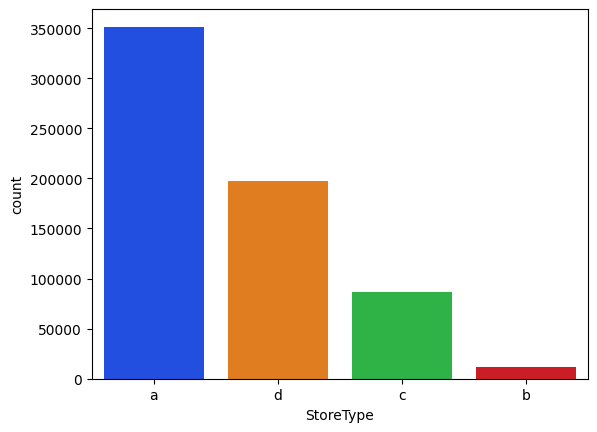

In [ ]:
sns.barplot(Train['StoreType'].value_counts(),palette='bright',)

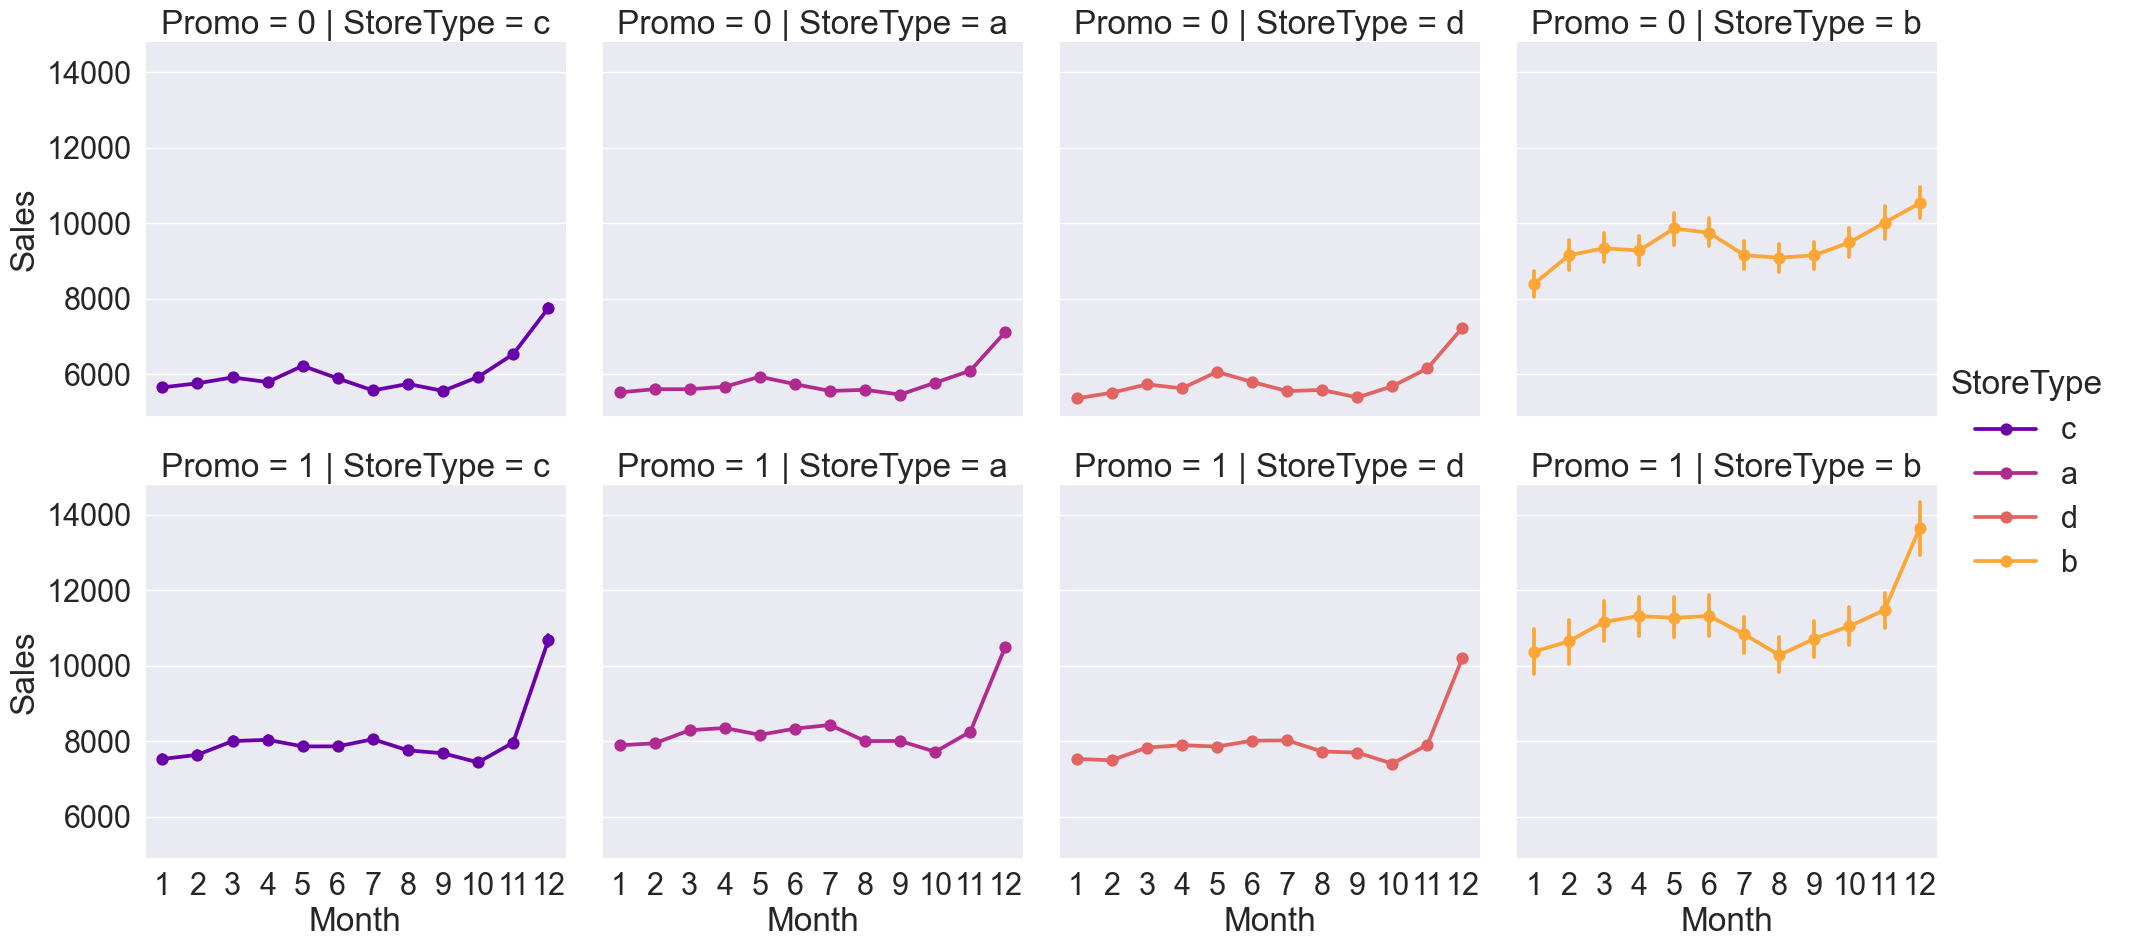

In [ ]:
sns.set(font_scale=2)
sns.catplot(
x='Month',
    y='Sales',
    data=Train,
    col='StoreType',
    palette='plasma',
    hue='StoreType',
    row='Promo',
    kind='point')

Sales
Promo StoreType         
0     a           5286.0
      b           8361.5
      c           5495.0
      d           5486.0
1     a           7639.0
      b          10064.0
      c           7523.5
      d           7555.0

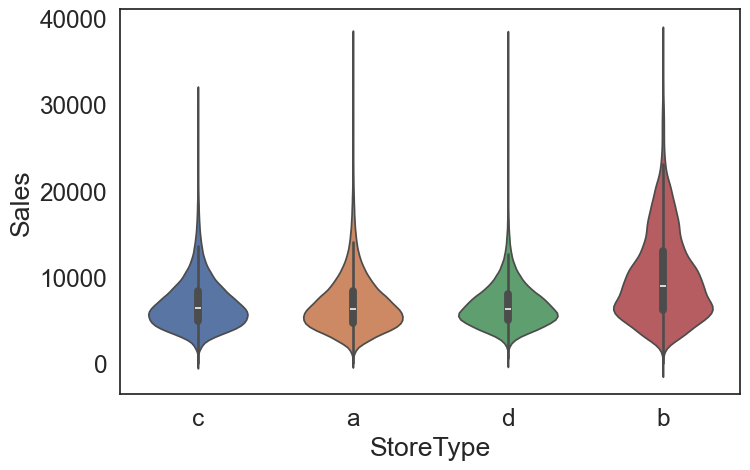

In [ ]:
sns.set_theme(font_scale=1.6,style='white')

plt.figure(figsize=(8,5))
sns.violinplot(Train,y='Sales',x='StoreType',gap=.2,hue='StoreType')

pd.set_option('display.max_rows',24)
Train[['Sales','Promo','StoreType']].groupby(['Promo','StoreType']).median()


In [ ]:
Promo0 ,Promo1 = (4386 + 4623 + 4761)/3,(7541 + 7437 +	7474)/3
# x * Promo0 = Promo1
X =  Promo1/Promo0
print("Factor by which sales are increased for StoreType a,d,c :",X)
print("Factor by which sales are increased for StoreType     b :",9939/ 8227)



Factor by which sales are increased for StoreType a,d,c : 1.6305010893246188

Factor by which sales are increased for StoreType     b : 1.2080952959766622


**Inference :**
- Sales are Increased by  factor  1.63 approximately for Store type **a,d,c** where store is running promo, But for Store **b** this increase  is of less magnitude(1.2 approx) then other, but in terms of Performance type **b** store performed well with and without promo.
- We can combine These features for better information gain.

In [13]:
for data in [Train,Test]:
    data['NewStoreType'] = data['StoreType'].replace({'a':'a,d,c','d':'a,d,c','c':'a,d,c'})

# CompetitionOpenSinceYear and CompetitionOpenSinceMonth

<Axes: xlabel='CompetitionOpenSinceMonth', ylabel='Sales'>

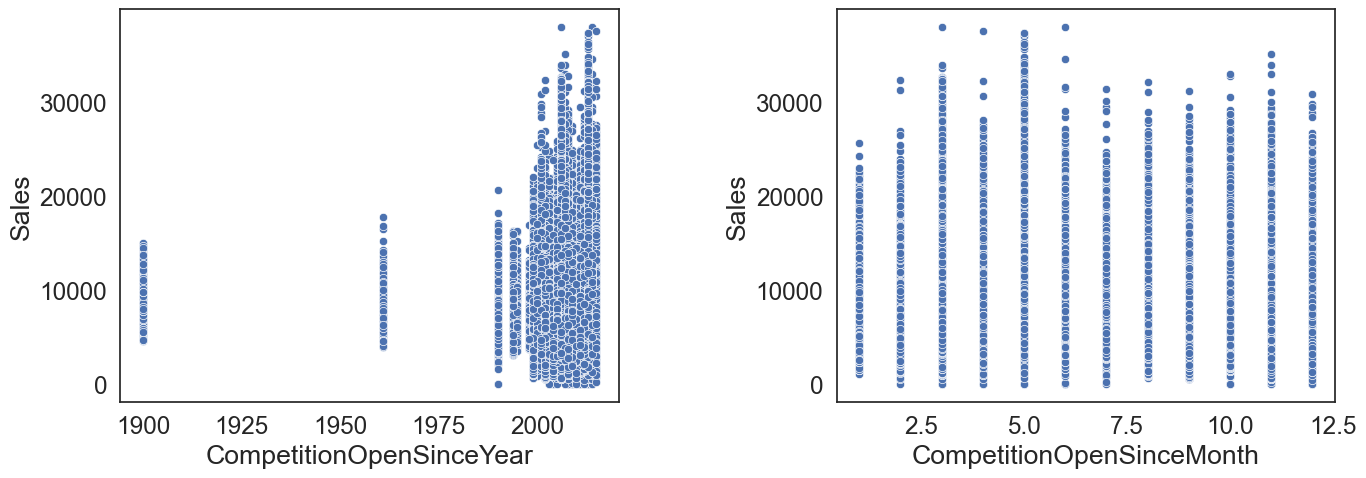

In [ ]:
fig, axes = plt.subplots(1,2)
plt.tight_layout()
fig.set_size_inches(15,5)
sns.scatterplot(Train,x='CompetitionOpenSinceYear',y='Sales',ax=axes[0],)
sns.scatterplot(Train,x='CompetitionOpenSinceMonth',y='Sales',ax=axes[1])

**Inferences :**  It seems that alone `CompetitionSinceYear` suggest Most of the competiter are new in market and our client is performing well among them but doesnt in front of old players. also their is no visible trend with `CompetitionSinceMonth`.

In [14]:
for data in [Train,Test]:
    data['CompetitionOpenAge'] = pd.Series(abs((data['Year'] - data['CompetitionOpenSinceYear']) + abs( data['CompetitionOpenSinceMonth'] - data['Month']))/12) # Calculating Age of competition

<Axes: xlabel='CompetitionOpenAge', ylabel='Sales'>

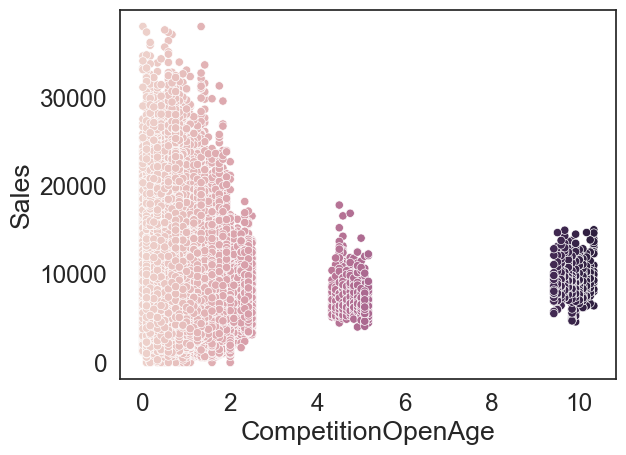

In [ ]:
sns.scatterplot(Train, x='CompetitionOpenAge',y='Sales',hue='CompetitionOpenAge',legend=False)

**Inference :**  Most of the competitors are from recent Years, In Term of Sales, Our client is Performing well among all recent players. But still Client have to work more, to perform great against Old players of industaries.

In [ ]:
print(f"No. of Not available values are same for Compitition Year and Month {Train['CompetitionOpenSinceMonth'].isna().sum()},{Train['CompetitionOpenSinceYear'].isna().sum()}")

print("Competition Details are Not Recorded and  It indicates no Competition Present in that area") if (len(Train)-(Train['CompetitionOpenSinceMonth'].isna() ==Train['CompetitionOpenSinceYear'].isna()).sum())==0 else print('Compition Details are missing We have to use Imputing Techninques')

No. of Not available values are same for Compitition Year and Month 206344,206344

Competition Details are Not Recorded and  It indicates no Competition Present in that area


In [15]:
for data in [Train,Test]:
    data['CompetitionOpenAge'].fillna(-1,inplace=True)
    bins = [-float('inf'), 3.5, 7.2, float('inf')]
    binned_data = pd.cut(data['CompetitionOpenAge'], bins,labels=['New','Mid','Exp'])
    pd.set_option('display.max_rows',20)
    data['CompetitionOpenAge'] = binned_data

<Axes: xlabel='CompetitionOpenAge', ylabel='Sales'>

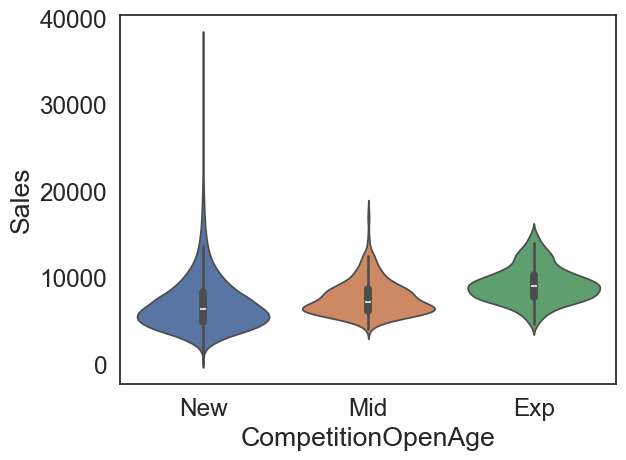

In [ ]:
sns.violinplot(Train, x='CompetitionOpenAge',y='Sales',hue='CompetitionOpenAge')

In [ ]:
pd.set_option('display.max_rows',100)
Train.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            1660
CompetitionOpenSinceMonth    206344
CompetitionOpenSinceYear     206344
Promo2                            0
Promo2SinceWeek              327231
Promo2SinceYear              327231
PromoInterval                327231
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
NewStoreType                      0
CompetitionOpenAge                0
dtype: int64

## Promo2

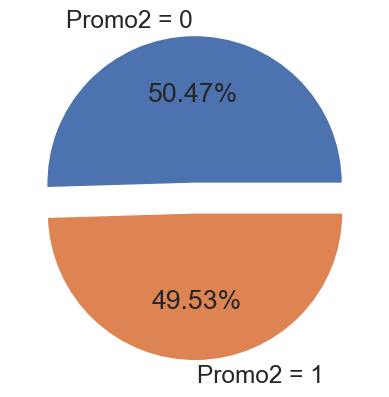

In [ ]:
plt.pie(Train['Promo2'].value_counts(),autopct='%.2f%%',explode =(.1,.1),labels=['Promo2 = 0','Promo2 = 1'])
plt.show()

In [ ]:
# pd.set_option('display.max_rows',50)
Train[['Promo2','Sales','Year']].groupby(['Promo2','Year']).agg(['mean','median','sum'])

Sales                    
                    mean  median         sum
Promo2 Year                                 
0      2013  7240.798890  6556.0  1197244374
       2014  7389.218743  6724.5  1196196287
1      2013  6405.894169  5911.0  1105631710
       2014  6628.887917  6126.0   984608609

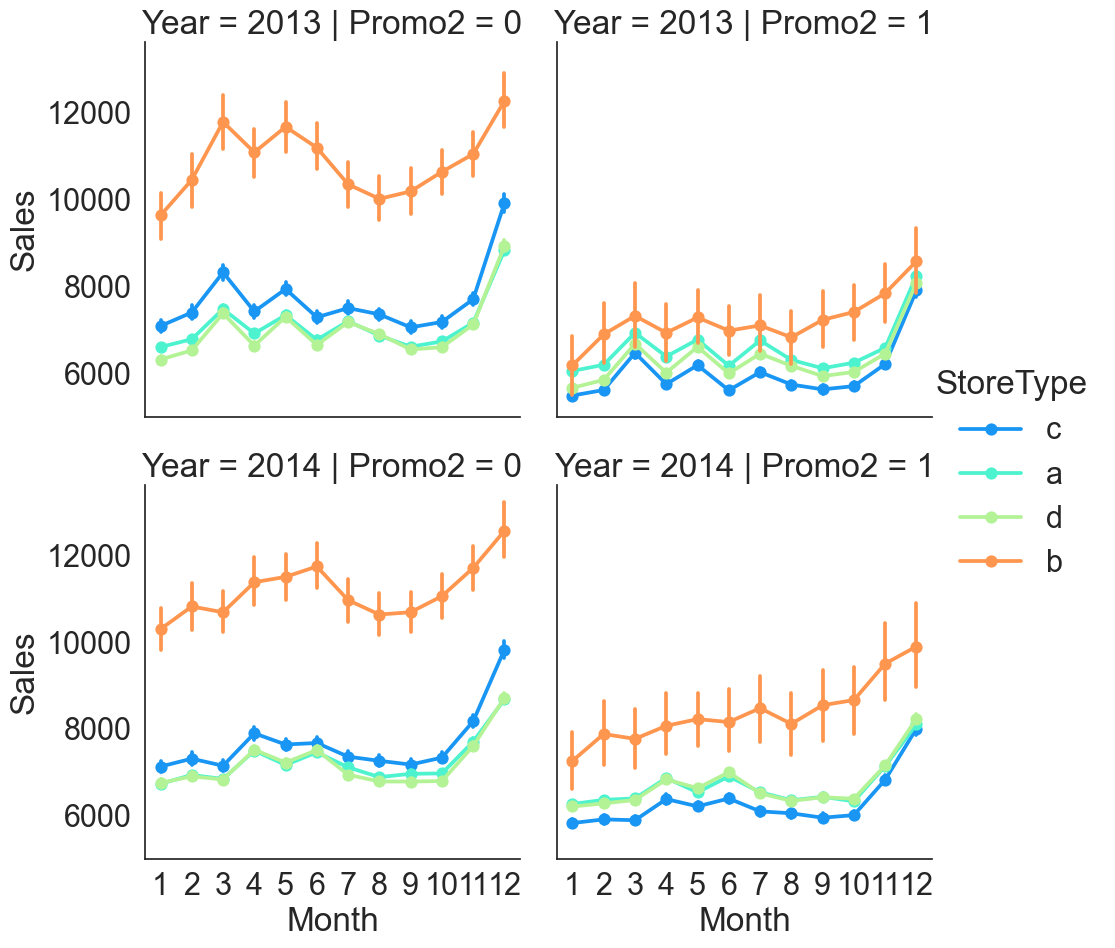

In [ ]:
sns.set_theme(font_scale=2,style='white')
fig = sns.catplot(
    x='Month',
    y='Sales',
    data=Train,
    col='Promo2',
    palette='rainbow',
    hue='StoreType',
    row='Year',
kind='point')

**Inference :** It seems Participating in Promo2 does not seems to be benificial for Stores. Even Our Best performer Store type **b** also faced downfall in overall sales.

# Promo2SinceYear, Promo2SinceWeek

<Axes: xlabel='Promo2SinceWeek', ylabel='Sales'>

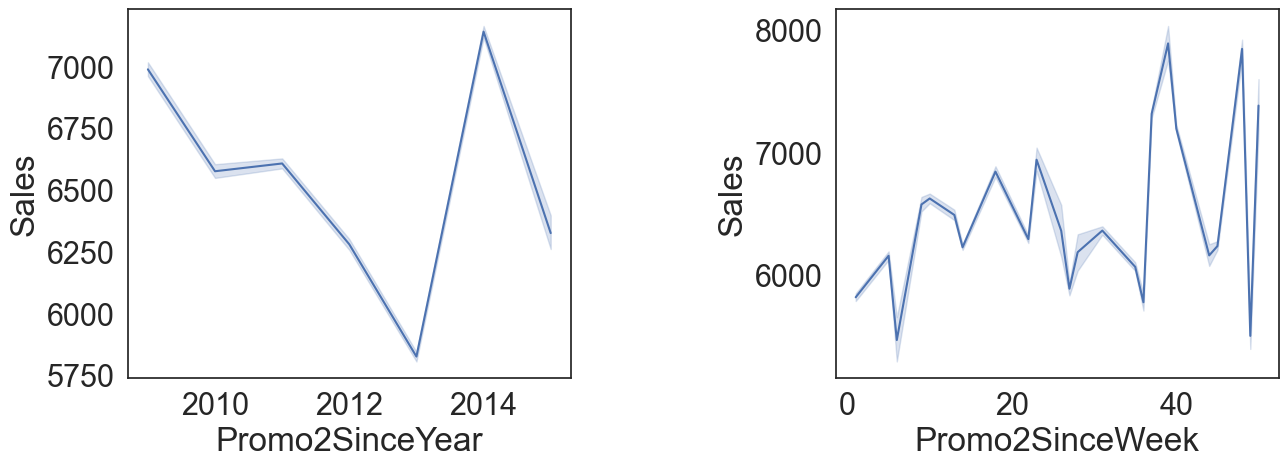

In [ ]:
fig, axes = plt.subplots(1,2)
plt.tight_layout()
fig.set_size_inches(15,5)
sns.lineplot(Train,x='Promo2SinceYear',y='Sales',ax=axes[0],)
sns.lineplot(Train,x='Promo2SinceWeek',y='Sales',ax=axes[1])

In [ ]:
# temp = 12 * abs(Train['Year'] -  Train['Promo2SinceYear']) +  abs(Train['WeekOfYear'] - Train['Promo2SinceWeek'])*7/30.5

# sns.kdeplot(temp.fillna(0))
# sns.kdeplot(temp.fillna(-1))
# del(temp)

In [16]:
for data in [Train,Test]:
    temp = 12 * abs(data['Year'] -  data['Promo2SinceYear']) +  abs(data['WeekOfYear'] - data['Promo2SinceWeek'])*7/30.5

    data['Promo2Open_Since'] = temp/12 # years
    del(temp)


In [ ]:
Train[['Promo2','Promo2Open_Since',]].groupby('Promo2').mean()

,Promo2Open_Since
Promo2,
0,<NA>
1,2.273321


In [17]:
for data in [Train,Test]:
    data['Promo2Open_Since'] = (data['Promo2Open_Since']).fillna(-1) # -1 indecates no participation in promo2

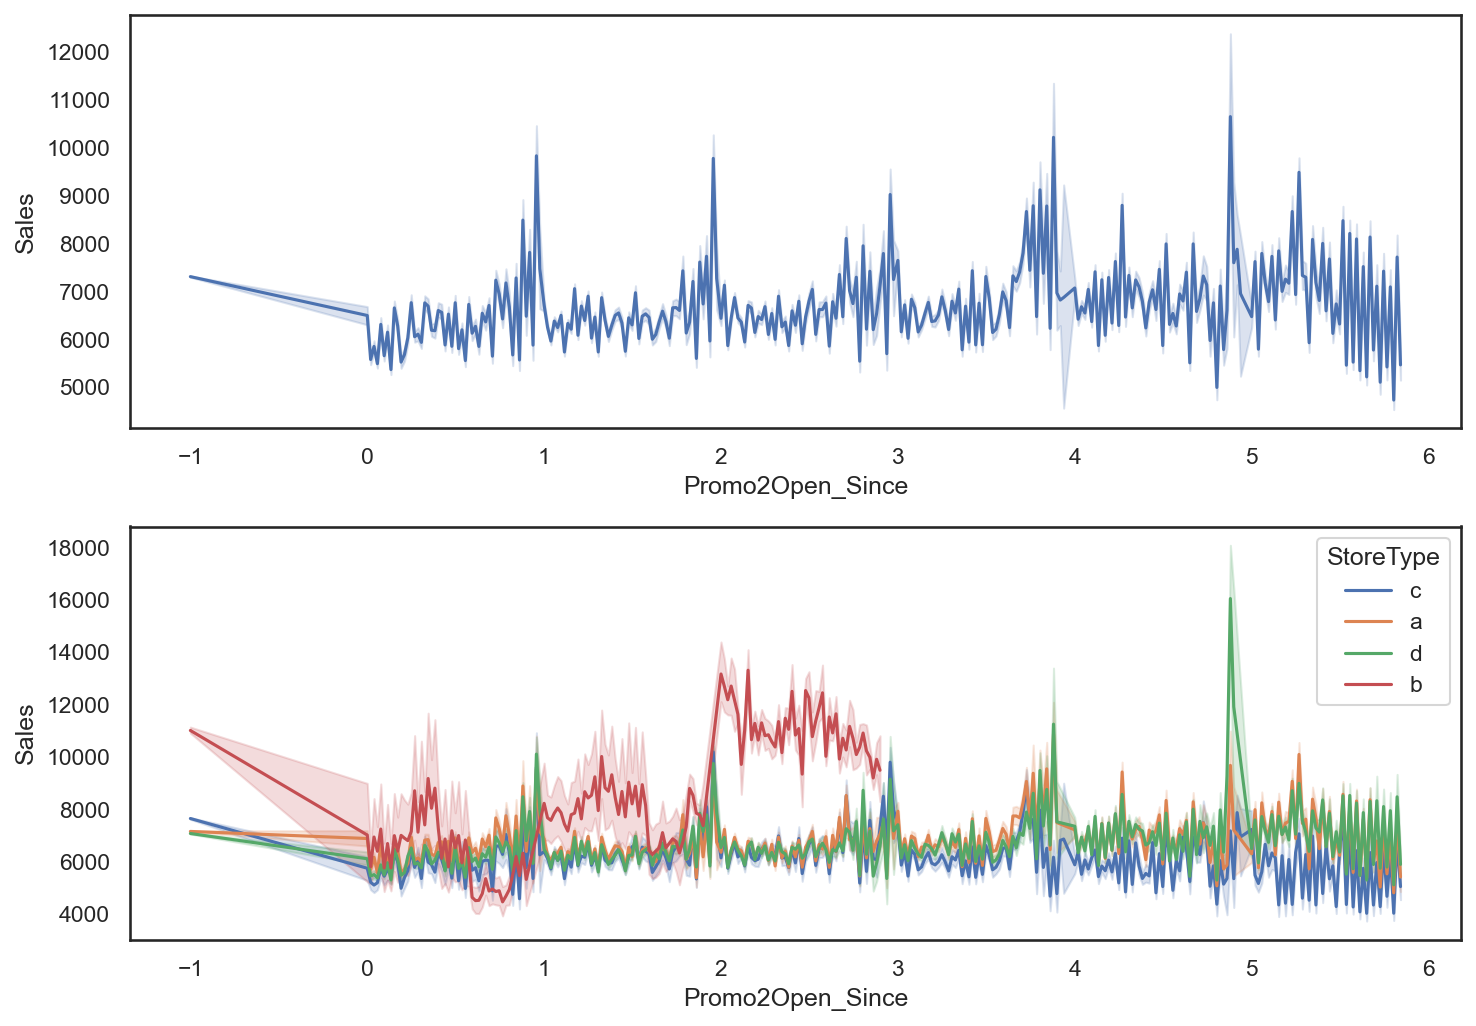

In [ ]:
sns.set(style='white')
fig,axes = plt.subplots(2,1,dpi=150)
fig.set_size_inches(10,7)
sns.lineplot(data=Train,
             x='Promo2Open_Since',
             y='Sales',ax=axes[0],estimator='mean')
sns.lineplot(data=Train,
             x='Promo2Open_Since',
             y='Sales',hue='StoreType',ax=axes[1],estimator='mean')
plt.tight_layout()

**Inference :** The Downward drift in sales proved Our Previous claim regarding not better Effect of participating in Promo2.  Store *TypeB* shown unstable increase in sales with lots of Fluctuations .


# Promo Interval


In [ ]:
Train['PromoInterval'].value_counts()

PromoInterval
Jan,Apr,Jul,Oct     183752
Feb,May,Aug,Nov      75310
Mar,Jun,Sept,Dec     62067
Name: count, dtype: int64

In [18]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] ).split(',')

        if  month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except :
        return 0

In [66]:
for data in [Train,Test]:
    temp = data.apply(check_promo_month,axis=1)
    data['IsActivePromo2Month'] = temp
    del(temp)

<Axes: xlabel='StoreType', ylabel='Sales'>

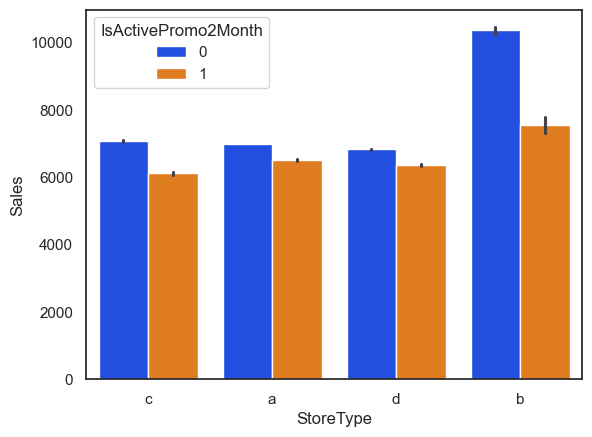

In [ ]:
Train['IsActivePromo2Month'].value_counts()

sns.barplot(data=Train,x='StoreType',y='Sales',hue='IsActivePromo2Month',estimator='mean',palette='bright')

In [ ]:
Train[['IsActivePromo2Month','Sales','StoreType']].groupby(['IsActivePromo2Month','StoreType']).agg(['mean','sum'])

Sales            
                                       mean         sum
IsActivePromo2Month StoreType                          
0                   a           6981.862838  2072028380
                    b          10355.291906   111816442
                    c           7066.636380   513235667
                    d           6829.829291  1094036205
1                   a           6503.776228   355776071
                    b           7549.766581     8765279
                    c           6109.803681    88292773
                    d           6365.475240   239730163

**Inferences** Here are another proofs against the -ve effect of **Continuing in Promo2**

In [ ]:
# to_analyse

# Customers

In [ ]:
Train['StoreType'].value_counts()

In [ ]:
Train[['Customers','Sales','StoreType']].groupby(['StoreType']).agg(['sum','mean'])

In [ ]:
fig,axes = plt.subplots(2,1,dpi=150)
sns.set_style('white')
fig.set_size_inches(5,7)

sns.barplot(Train,y ='Customers',x='StoreType',estimator='sum',ax=axes[0],palette='bright',)
axes[0].set_title('overall customers performance')
sns.barplot(Train,y ='Customers',x='StoreType',estimator='mean',ax=axes[1],palette='bright')
axes[1].set_title('avg customers performance')
plt.tight_layout()

In [ ]:
Train[Train['Customers']==0]['Sales']

**Inferences :** Again In terms of Customers serving performance StoreType **b** has proven good. Also

In [67]:
Train = Train[Train['Customers']>0]
Test = Test[Test['Customers']>0]

In [ ]:
# row = 3

# months = (Train['PromoInterval'][row].split(','))
# # print(months)
# print("Promo2 Interval",months)
# print("Open for Promo2 since months : ",Train.iloc[row]['Promo2Open_Since'])
# print("Current Month",month2str[Train['Month'][row]] )
# print("" ,(month2str[Train['Month'][row]] in months))
# data[data['CompetitionDistance'].isna() ==False]['CompetitionDistance'].sample(len(indexes_of_na))
# dfs

# Competitioin Distance

In [ ]:
temp = Train['CompetitionDistance'].copy()



In [ ]:
Train[ np.logical_not(Train['CompetitionOpenSinceMonth'] + Train['CompetitionOpenSinceYear']).isna()]

In [68]:
for data in [Train,Test]:
    indexes_of_na = data[data['CompetitionOpenSinceMonth'].isna() & data['CompetitionOpenSinceYear'].isna() & data['CompetitionDistance'].isna()].index
    print(len(indexes_of_na),data['CompetitionDistance'].isna().sum())
    data.loc[indexes_of_na,'CompetitionDistance'] =  list(data[data['CompetitionDistance'].isna() ==False]['CompetitionDistance'].sample(len(indexes_of_na)))
    del(data)
    del(indexes_of_na)




1660 1660

526 526


In [ ]:
temp.isna().sum()

In [ ]:


sns.histplot(Train['CompetitionDistance'],kde=True,bins=30)


In [ ]:
(Train['CompetitionDistance']//1000).hist()

In [69]:
for data in [Train,Test]:
   data['CompetitionDistance'].clip(0,10000,inplace=True)

In [ ]:
Train['CompetitionDistance']

In [ ]:
sns.histplot(Train['CompetitionDistance'],kde=True,bins=30)

# Holidays [StateHoliday and SchoolHolidays]

In [70]:
for data in [Train,Test]:
    data['StateHoliday'] = data['StateHoliday'].replace({'0':'NoHoliday','a':'PublicHoliday','b':'EasterHoliday','c':'Christmas',0:'NoHoliday'})

In [ ]:
print(Train['SchoolHoliday'].value_counts())
print()
print(Train['StateHoliday'].value_counts())

In [ ]:
Train[['StateHoliday','SchoolHoliday','Sales']].groupby(['StateHoliday','SchoolHoliday']).mean()

# Assortment

In [71]:
for data in [Train,Test]:
    data['Assortment'] = data['Assortment'].replace({ 'a': 'basic','b':'extra','c': 'extended'})


In [ ]:
Train[['Assortment','Sales']].groupby('Assortment').agg(['mean','count'])

In [ ]:
sns.violinplot(data=Train,y='Sales',hue='Assortment',gap=.2,palette='bright')

In [ ]:
Train["Assortment"].value_counts()

In [ ]:
pd.set_option('display.max_columns',40)
Train.sample(5)

In [72]:
input_features = ['Store', 'DayOfWeek', 'Customers','Promo', 'StateHoliday', 'SchoolHoliday',
                  'Assortment', 'CompetitionDistance','Promo2',
              'Day', 'Month', 'Year', 'WeekOfYear', 'NewStoreType','CompetitionOpenAge',
              'Promo2Open_Since', 'IsActivePromo2Month']

numeric_cols = ['Store','DayOfWeek','Customers' ,'Promo', 'SchoolHoliday',
              'CompetitionDistance','Promo2', 'Day', 'Month', 'Year',
              'WeekOfYear',  'Promo2Open_Since', 'IsActivePromo2Month',
               ]
categorical_cols = ['StateHoliday','NewStoreType']
ordinal_cols = [  'Assortment','CompetitionOpenAge']

target = 'Sales'
print("No. of Input Features",len(input_features))
print("No. of Numerical Input Features",len(numeric_cols))
print("No. of Categorical Input Features",len(categorical_cols))
print("No. of Ordinal Input Features",len(ordinal_cols))

No. of Input Features 17

No. of Numerical Input Features 13

No. of Categorical Input Features 2

No. of Ordinal Input Features 2


In [73]:

X = Train[input_features].copy()
Y = Train[target].copy()
X_Test = Test[input_features].copy()
Y_Test = Test[target].copy()
del(Train)
del(Test)

In [ ]:
X.isna().sum()

In [ ]:
X_Test.isna().sum()

In [75]:
Scaler = StandardScaler().fit(X[numeric_cols])
encoder = OneHotEncoder(sparse_output=False,drop='first').fit(X[categorical_cols])
ordinal = OrdinalEncoder(dtype=np.uint8).fit(X[ordinal_cols])

In [76]:
X[numeric_cols] = Scaler.transform(X[numeric_cols])
X_Test[numeric_cols] = Scaler.transform(X_Test[numeric_cols])

encoded_Features = list(encoder.get_feature_names_out())

X[encoded_Features] = encoder.transform(X[categorical_cols])
X_Test[encoded_Features] = encoder.transform(X_Test[categorical_cols])

ordinal_Features = list(ordinal.get_feature_names_out())

X[ordinal_Features] = ordinal.transform(X[ordinal_cols])
X_Test[ordinal_Features] = ordinal.transform(X_Test[ordinal_cols])

In [77]:
X = X[numeric_cols+encoded_Features+ordinal_Features]
X_Test = X_Test[numeric_cols+encoded_Features +ordinal_Features]

In [78]:

X.memory_usage().sum()/1024**2

106.3935604095459

In [79]:
def reduce_mem_usage(df,Dense=False, verbose=True):
    import numpy as np
    if Dense:

        df = df.copy()


    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            if col_type==object:
                df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [80]:
reduce_mem_usage(X)
reduce_mem_usage(X_Test)


Mem. usage decreased to 64.35 Mb (39.5% reduction)

Mem. usage decreased to 18.61 Mb (40.6% reduction)


,Store,DayOfWeek,Customers,Promo,SchoolHoliday,CompetitionDistance,Promo2,Day,Month,Year,WeekOfYear,Promo2Open_Since,IsActivePromo2Month,StateHoliday_EasterHoliday,StateHoliday_NoHoliday,StateHoliday_PublicHoliday,NewStoreType_b,Assortment,CompetitionOpenAge
0,-1.733038,0.859437,-0.520519,1.127654,1.979028,-0.708405,-0.99060,1.751070,0.175238,3.045227,0.340686,-0.836447,-0.44699,0.0,1.0,0.0,0.0,0,2
1,-1.733038,0.280023,-0.542740,1.127654,1.979028,-0.708405,-0.99060,1.636040,0.175238,3.045227,0.340686,-0.836447,-0.44699,0.0,1.0,0.0,0.0,0,2
2,-1.733038,-0.299390,-0.599526,1.127654,1.979028,-0.708405,-0.99060,1.521010,0.175238,3.045227,0.340686,-0.836447,-0.44699,0.0,1.0,0.0,0.0,0,2
3,-1.733038,-0.878803,-0.508175,1.127654,1.979028,-0.708405,-0.99060,1.405980,0.175238,3.045227,0.340686,-0.836447,-0.44699,0.0,1.0,0.0,0.0,0,2
4,-1.733038,-1.458216,-0.379789,1.127654,1.979028,-0.708405,-0.99060,1.290950,0.175238,3.045227,0.340686,-0.836447,-0.44699,0.0,1.0,0.0,0.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016472,1.729692,-0.299390,-0.930366,1.127654,1.979028,0.415938,1.00949,-1.009654,-1.568720,3.045227,-1.595127,1.424609,-0.44699,0.0,1.0,0.0,0.0,1,2
1016473,1.729692,-0.878803,-0.804449,1.127654,1.979028,0.415938,1.00949,-1.124684,-1.568720,3.045227,-1.595127,1.424609,-0.44699,0.0,1.0,0.0,0.0,1,2
1016474,1.729692,-1.458216,-0.458796,1.127654,1.979028,0.415938,1.00949,-1.239714,-1.568720,3.045227,-1.595127,1.424609,-0.44699,0.0,1.0,0.0,0.0,1,2
1016476,1.729692,1.438850,-0.732849,-0.886797,1.979028,0.415938,1.00949,-1.469774,-1.568720,3.045227,-1.661880,1.434477,-0.44699,0.0,1.0,0.0,0.0,1,2


In [ ]:
plt.figure(figsize=(18,15))
sns.heatmap(pd.concat((X,Y),axis=1).corr(),annot=True,fmt='.2g',linecolor='white',linewidths=.6)

**Inferences**
- **Customers** and **Promo** are most linearly correlated with Sales.
- Other features shown neutral linear correlation, It might be because these features have non-linear correlation with Sales or No correlation.
- So we are going to use Model with Non linear Hyponthesis

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

In [ ]:
# %cd /gdrive

In [ ]:
# os.getcwd()

In [ ]:
# !pip install pd
# # import pd

In [82]:
# os.makedirs('data/Train/X',exist_ok=True)
# os.makedirs('data/Train/Y',exist_ok=True)
# os.makedirs('data/Test/X',exist_ok=True)
# os.makedirs('data/Test/Y',exist_ok=True)

X.to_csv('/content/drive/MyDrive/PlacementProject/data/Train/X/X.csv',index=False)
Y.to_csv('/content/drive/MyDrive/PlacementProject/data/Train/Y/Y.csv',index=False)
X_Test.to_csv('/content/drive/MyDrive/PlacementProject/data/Test/X/X_Test.csv',index=False)
Y_Test.to_csv('/content/drive/MyDrive/PlacementProject/data/Test/Y/Y_Test.csv',index=False)


# import pandas as pd
# X = pd.read_csv.('/content/drive/MyDrive/PlacementProject/data/Train/X/X.csv')
# Y = pd.read_csv('/content/drive/MyDrive/PlacementProject/data/Train/Y/Y.csv')
# X_Test = pd.read_csv('/content/drive/MyDrive/PlacementProject/data/Test/X/X_Test.csv')
# Y_Test = pd.read_csv('/content/drive/MyDrive/PlacementProject/data/Test/Y/Y_Test.csv')



In [1]:

# X = pd.read_csv('data/Train/X/X.csv')
# Y = pd.read_csv('data/Train/Y/Y.csv')
# X_Test = pd.read_csv('data/Test/X/X_Test.csv')
# Y_Test = pd.read_csv('data/Test/Y/Y_Test.csv')

import cudf
X = cudf.read_csv('/content/drive/MyDrive/PlacementProject/data/Train/X/X.csv')
Y = cudf.read_csv('/content/drive/MyDrive/PlacementProject/data/Train/Y/Y.csv')
X_Test = cudf.read_csv('/content/drive/MyDrive/PlacementProject/data/Test/X/X_Test.csv')
Y_Test = cudf.read_csv('/content/drive/MyDrive/PlacementProject/data/Test/Y/Y_Test.csv')

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:



stdout:







stderr:



Traceback (most recent call last):

  File "<string>", line 4, in <module>

  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__

    raise CudaSupportError("Error at driver init: \n%s:" %

numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 



CUDA driver library cannot be found.

If you are sure that a CUDA driver is installed,

try setting environment variable NUMBA_CUDA_DRIVER

with the file path of the CUDA driver shared library.

:





Not patching Numba

  warnings.warn(msg, UserWarning)

/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1

  warnings.warn(str(e))


ImportError: 
================================================================
Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory
================================================================


In [86]:
from xgboost import XGBRegressor


In [ ]:
xgboost.__version__ # '2.0.3'

'2.0.3'

In [87]:
initial_model = XGBRegressor(device='gpu',verbosity=1)

In [88]:
initial_model.fit(X,Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [102]:
Y_array = Y.to_numpy()
Y_Test_array  = Y_Test.to_numpy()


In [106]:

print('Training error :',root_mean_square_error(Y_array,initial_model.predict(X)))
print('Testing error :',root_mean_square_error(Y_Test_array,initial_model.predict(X_Test)))

Training error : 613.8789749706062

Testing error : 762.0649632366931


In [150]:
scores =cross_val_score(estimator=initial_model,X=X.to_numpy(),y=Y.to_numpy(),cv=5,scoring='neg_root_mean_squared_error',error_score="raise")


In [152]:
print(scores)
print(scores.mean())

[-1874.24888435 -1318.16740664 -1333.51533676 -1397.75270788

 -1595.11747949]

-1503.760363023242


In [159]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': initial_model.feature_importances_
}).sort_values('Importance', ascending=False)

In [160]:
importance_df

,Feature,Importance
2,Customers,0.412206
16,NewStoreType_b,0.200899
3,Promo,0.089150
17,Assortment,0.074265
5,CompetitionDistance,0.036095
1,DayOfWeek,0.023452
6,Promo2,0.022389
11,Promo2Open_Since,0.021969
10,WeekOfYear,0.021816
8,Month,0.021555


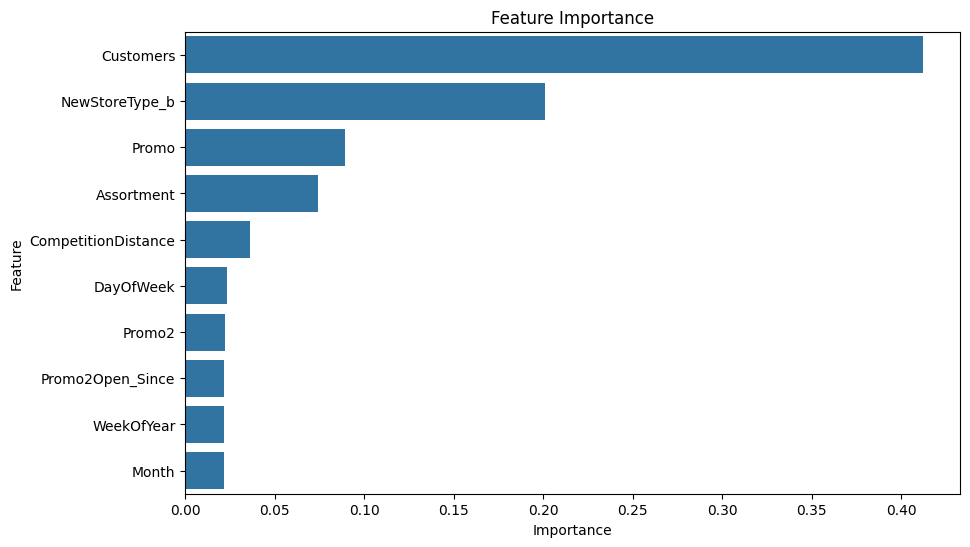

In [161]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature');

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input


In [163]:
model = Sequential()

In [ ]:
model.add(Input(shape=(X.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
train_and_evaluate(XGBRegressor,X,Y,X_Test,Y_Test,device='gpu',random_state=42
                   ,n_estimators=100,)

In [ ]:
train_and_evaluate(XGBRegressor,X,Y,X_Test,Y_Test,device='gpu',random_state=42
                   ,n_estimators=60,)

In [ ]:
train_and_evaluate(XGBRegressor,X,Y,X_Test,Y_Test,device='gpu',random_state=42
                   ,n_estimators=100,learning_rate=0.1)

In [ ]:
train_and_evaluate(XGBRegressor,X,Y,X_Test,Y_Test,device='gpu',random_state=42
                   ,n_estimators=100,learning_rate=0.3)

In [ ]:
train_and_evaluate(XGBRegressor,X,Y,X_Test,Y_Test,device='gpu',random_state=42
                   ,n_estimators=100,learning_rate=0.5)

In [ ]:
train_and_evaluate(XGBRegressor,X,Y,X_Test,Y_Test,device='gpu',random_state=42
                   ,n_estimators=100,learning_rate=0.9)

In [ ]:
train_and_evaluate(XGBRegressor,X,Y,X_Test,Y_Test,device='gpu',random_state=42
                   ,n_estimators=100,learning_rate=0.3,max_depth=5)

In [ ]:
train_and_evaluate(XGBRegressor,X,Y,X_Test,Y_Test,device='gpu',random_state=42
                   ,n_estimators=100,learning_rate=0.3,max_depth=10)

In [ ]:
train_and_evaluate(XGBRegressor,X,Y,X_Test,Y_Test,device='gpu',random_state=42
                   ,n_estimators=100,learning_rate=0.3,max_depth=12)

In [ ]:
train_and_evaluate(XGBRegressor,X,Y,X_Test,Y_Test,device='gpu',random_state=42
                   ,n_estimators=100,learning_rate=0.3,max_depth=12)

In [153]:
xgb= XGBRegressor(device='gpu',n_jobs=-1, random_state=42, n_estimators=100,
                     learning_rate=0.2, max_depth=12, )
xgb.fit(X,Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [154]:
xgb.score(X_Test.to_numpy(),Y_Test.to_numpy())

0.9535468816406557

In [156]:
from sklearn.model_selection import cross_val_score
scores =cross_val_score(estimator=xgb,X=X.to_numpy(),y=Y.to_numpy(),cv=5,scoring='neg_root_mean_squared_error',error_score="raise")

In [157]:
print(scores)
scores.mean()

[-1475.56842291 -1392.9206794  -1329.24550127 -1368.02164145

 -1434.0878477 ]


-1399.9688185449195

0.7391394931798377

In [ ]:
Y_Test_pred = xgb.predict(X_Test)

In [ ]:

for data in [X,X_Test]:
  # data.drop('Date',axis=1,inplace=True)
  data['Date'] =  data[['Year','Month','Day']].apply(lambda x: str(x[0])+ '-' +str(x[1])+ '-' + str(x[2]),axis=1)


In [ ]:
Y

In [ ]:
final =  pd.DataFrame({'Date':list(X['Date'])+ list(X_Test['Date']),'Sales':list(Y) + list(Y_Test_pred)})

In [ ]:
pd.DataFrame({'Date':X['Date'].values,'Sales':Y.values})

In [ ]:
X['Sales'] = Y
X['Ind'] = 0
X_Test['Ind'] = 1

X_Test['Sales'] = Y_Test


In [ ]:
final=pd.concat((X[['Sales','Date']],X_Test[['Sales','Date']]),axis=0)

In [ ]:
plt.figure(figsize=(14, 7))

# Actual sales
plt.plot(scalex='Date', scaley='Sales', data=X[(X['Year']>2013) & (X['Month']>8)] )


# plt.plot(scalex=X_Test['Date'].values,scaley= Y_Test_pred, color='orange')

In [ ]:
sns.

In [ ]:

plt.figure(figsize=(14, 7))

# Actual sales
sns.lineplot(x='Date', y='Sales', data=X,hue='Ind',units= )


# sns.lineplot(x=X_Test['Date'],y= Y_Test_pred, color='orange')

In [ ]:
sns.lineplot??